In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [119]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats
import numpy as np
import random


set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]

In [2]:
from models.hardnet_segm import HardNetSegm
import cv2
import torch
from models.bts_estimator import BTSEstimator
from plane_detector import PlaneDetector
from models.midas_estimator import MIDASEstimator
from ransac_detector import crop_depth_map, get_connected_components, DEFAULT_CAM

In [3]:
hardnet_path = "models/segmnetator/hardnet70_cityscapes_model_2.pkl"
bts_path = "models/depth_estimator/models/bts_latest"


depth_model = MIDASEstimator()
segm_model = HardNetSegm(hardnet_path)

Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ruslan/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master


In [4]:
model = PlaneDetector(depth_model, segm_model)

In [272]:
%%time 
import os
import seaborn as sns
from tqdm import tqdm


path = "/home/ruslan/Документы/startup/FCHarDNet/data/leftImg8bit/val/frankfurt/"
files = os.listdir(path)

images = [cv2.resize(cv2.imread(path + item), (640, 480)) for item in tqdm(files)]

100%|██████████| 267/267 [00:18<00:00, 14.23it/s]

CPU times: user 19.1 s, sys: 923 ms, total: 20.1 s
Wall time: 18.8 s


In [225]:
from functools import reduce


def close_map(map_arr, kernels=None):
    """
    Function used for filling holes in map_arr
    :param map_arr: initial map_arr
    :param kernels: tuple of kernels used to fill holes in map
    :return: relusting map_arr after closing
    """
    if kernels is None:
        kernels = [np.ones((100, 10), np.uint8), np.ones((10, 100), np.uint8)]

    ls_closings = [cv2.morphologyEx(np.uint8(map_arr), cv2.MORPH_CLOSE, kernel) for kernel in kernels]
    return reduce(np.logical_and, ls_closings, np.ones(map_arr.shape))



def straight_pcd(map_arr, depth_map, plane_model):
    a, b, c, d = plane_model
    img = o3d.geometry.Image(np.float32(map_arr * depth_map))
    result = o3d.geometry.PointCloud.create_from_depth_image(img, DEFAULT_CAM)
    result.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    arr = np.asarray(result.points)
    new_points = np.array([[x, y, (-a * x - b * y - d) / c] for x, y, z in arr])
    vec = o3d.utility.Vector3dVector(new_points)
    result.points = vec
    return result


In [266]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist
from sklearn.neighbors.nearest_centroid import NearestCentroid
from collections import defaultdict
from functools import reduce
import copy
from ransac_detector import *
import scipy.spatial.distance as ds


import scipy.cluster.hierarchy as sch

import numpy as np
from functools import partial
import copy
from sklearn.metrics import pairwise_distances

def loss_metric(true_pcd: o3d.geometry.PointCloud, approx_pcd: o3d.geometry.PointCloud, func="rmse") -> float:
    """
    :param true_pcd:
    :param approx_pcd:
    :param func:
    :return:
    """
    funcs = {
        "rmse": (lambda x, y: ((x - y) * 1000) ** 2, lambda x, n: np.sqrt(x / n)),
        "mae": (lambda x, y: abs((x - y) * 1000), lambda x, n: x / n), 
        "mse": (lambda x, y: ((x - y) * 1000) ** 2, lambda x, n: x / n)
    }
    true_arr = np.asarray(true_pcd.points)
    approx_arr = np.asarray(approx_pcd.points)
    loss = 0
    for x, y in zip(true_arr, approx_arr):
        loss += funcs[func][0](x[-1], y[-1])
    return funcs[func][1](loss, len(true_arr))



def thr_func(q):
    return partial(np.quantile, q=q)


def _distance_func(v1, v2, th=0.001):
    if abs(v1[-1] - v2[-1]) > th:
        return 1.0
    return ds.cosine(v1[:-1], v2[:-1])


def dist(func):
    return partial(pairwise_distances, metric=func)



def get_plane_img(img, ls_map_arrs):
    """
    Function to plot detected planes on picture
    :param img:
    :param ls_map_arrs:
    :return:
    """
    res = copy.deepcopy(img)
    for map_arr in ls_map_arrs:
        color = [random.randint(1, 255) for _ in range(3)]
#         print(map_arr)
        ind = np.where(map_arr)
#         print(ind)

        res[ind[0], ind[1], :] = color
    return res


clf = NearestCentroid(metric='cosine')

clust = AgglomerativeClustering(n_clusters=None, 
                                affinity=dist(_distance_func), 
                                linkage="average", 
                                compute_full_tree=True, 
                                distance_threshold=0.2)

def merge_planes(ls_vectors_planes, ls_maps_planes, clust=clust, clf=clf):
    if len(ls_vectors_planes) < 2:
        return ls_vectors_planes, ls_maps_planes
    preds = clust.fit_predict(ls_vectors_planes)
    if len(set(preds)) < 2:
#         print("kek")
#         print(ls_maps_planes, ls_maps_planes[0].shape)
        return [np.mean(ls_vectors_planes, axis=0)], [reduce(np.logical_or, ls_maps_planes, np.zeros(ls_maps_planes[0].shape))]
    clf.fit(ls_vectors_planes, preds)
    centroids = {cls: vect for cls, vect in zip(clf.classes_, clf.centroids_)}
    dd = defaultdict(list)
    for cls, map_arr in zip(preds, ls_maps_planes):
        dd[cls].append(map_arr)
    planes = []
    vectors = []
    for item in dd:
        res_map = reduce(np.logical_or, dd[item], np.zeros(dd[item][0].shape))
        planes.append(res_map)
        vectors.append(centroids[item])
    return vectors, planes


kernels = [np.ones((150, 20), np.uint8), np.ones((20, 150), np.uint8)]

def normal_depth(depth_map):
    vect_func = np.vectorize(lambda x: 1 / x if x > 0 else x)
    res = vect_func(depth_map)
    return res

def _get_full_cycle(img, classes=[{0, 1}]):
    depth_map, seg_map, ls_map_arr = model.get_segmented_depth(img, classes)
    ls_right_depths = []
    funcs = [thr_func(0.95), np.mean]
    n_depth = normal_depth(depth_map)
    for item, f_th in zip(ls_map_arr, funcs):
        tmp, _ = crop_depth_map(depth_map * item, f_th)
        ls_right_depths.extend(get_connected_components(tmp, threshold=0.3))
    
    ls_maps_planes = []
    ls_vectors_planes = []
    for dd, map_arr in ls_right_depths:
        if map_arr.sum() >= int(0.1 * N):
            result = extract_planes_con(map_arr, dd, map_arr.sum(), 0.2)
            ls_maps_planes.extend([arr for arr, _ in result])
            ls_vectors_planes.extend([arr for _, arr in result])
    ls_maps_planes = [close_map(item, kernels=kernels) for item in ls_maps_planes]

#     print(ls_maps_planes)
    ls_vectors_planes, ls_maps_planes = merge_planes(ls_vectors_planes, ls_maps_planes)
    ls_maps_planes = [close_map(item, kernels=kernels) for item in ls_maps_planes]
#     print(ls_vectors_planes)
    
    # list of initial pcd
    ls_init_pcd = []
    for item in ls_maps_planes:
        tmp = o3d.geometry.Image(np.float32(n_depth * item))
        pcd = o3d.geometry.PointCloud.create_from_depth_image(tmp, DEFAULT_CAM)
        pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        ls_init_pcd.append(pcd)
    
    # list of straingt pcd
    ls_straight_pcd = []
    for item, (a, b, c, d) in zip(ls_maps_planes, ls_vectors_planes):
        ls_straight_pcd.append(straight_pcd(item, n_depth, (a, b, c, d)))
    
    sqew = []
    loss = []
    for x, y in zip(ls_init_pcd, ls_straight_pcd):
        loss.append(loss_metric(x, y))
        sqew.append(abs(np.max(np.asarray(x.points)) - np.min(np.asarray(x.points))) * 1000)    
    res_img = get_plane_img(img, ls_maps_planes)
    return res_img, ls_vectors_planes, ls_maps_planes, loss, sqew


In [273]:
ls_loss = []
ls_sqew = []
for img in tqdm(images):
    _, _, _, loss, sqew = _get_full_cycle(img)
    ls_loss.extend(loss)
    ls_sqew.extend(sqew)

100%|██████████| 267/267 [12:43<00:00,  2.86s/it]


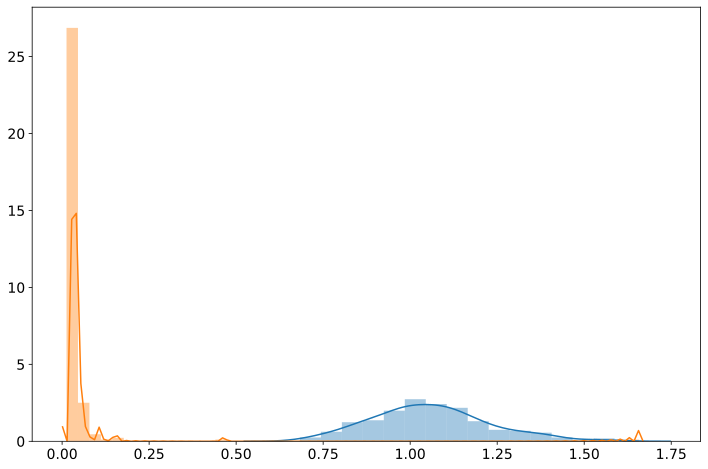

In [274]:
sns.distplot(ls_sqew)
sns.distplot(ls_loss)

In [275]:
ls_loss = []
ls_sqew = []
for img in tqdm(images):
    _, _, _, loss, sqew = _get_full_cycle(img, classes=[{2}])
    ls_loss.extend(loss)
    ls_sqew.extend(sqew)

100%|██████████| 267/267 [10:19<00:00,  2.32s/it]


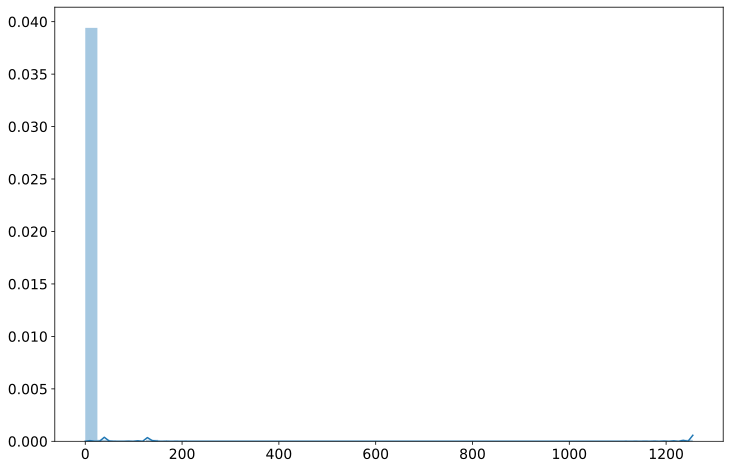

In [300]:
# sns.distplot(ls_sqew)
sns.distplot(ls_loss)

In [281]:
np.median(ls_loss), np.median(ls_sqew)

(0.09084868092550855, 2.4352356474403116)

In [282]:
np.argmax(ls_loss)

40

In [271]:
np.median(ls_loss)

0.09482603581950363

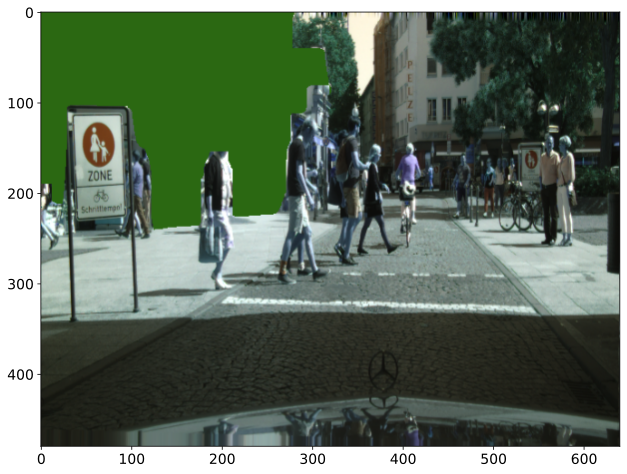

In [283]:
plt.imshow(_get_full_cycle(images[40], classes=[{2}])[0])

In [284]:
from models.depth_estimator.BTS import BtsController


# img = cv2.imread("/home/ruslan/Документы/startup/research/data/paris/73_location_48.8611316,2.3401685/120/gsv_0.jpg")
# img = cv2.imread("/home/ruslan/Загрузки/72ac1342-b976-48ad-9c20-9197707c7e62.jpeg")
# img = cv2.imread("/home/ruslan/Загрузки/test_corner2.jpg")
img = copy.deepcopy(images[40])
img = cv2.resize(img, (640, 480))
depth_map, seg_map, ls_map_arr = model.get_segmented_depth(img, [{0, 1}, {2}])

In [285]:
N = 640 * 480

In [286]:
ls_right_depths = []
ls_tmp = []
funcs = [thr_func(0.95), np.mean]
for item, fun in zip(ls_map_arr, funcs):
    tmp, k = crop_depth_map(depth_map * item, fun)
    ls_right_depths.extend(get_connected_components(tmp, threshold=0.3))


In [287]:
import open3d as o3d
import os
import sys
import cv2

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

In [288]:
%%time
ls_right_map_arrs = [np.where(item[0] > 0, 1, 0) for item in ls_right_depths]
ls_maps_planes = []
ls_vectors_planes = []
for dd, map_arr in zip(ls_right_depths, ls_right_map_arrs):
    result = extract_planes_con(map_arr, dd[0], map_arr.sum(), 0.2)
    ls_maps_planes.extend([arr for arr, _ in result])
    ls_vectors_planes.extend([arr for _, arr in result])

CPU times: user 320 ms, sys: 8 ms, total: 328 ms
Wall time: 431 ms


In [289]:
ls_vectors_planes

[array([2.03037695e-02, 9.87327705e-01, 1.57390469e-01, 1.05435038e-04]),
 array([9.21732552e-01, 5.49393594e-02, 3.83915056e-01, 4.13106941e-04]),
 array([9.13030451e-01, 6.61729239e-02, 4.02487936e-01, 4.00249839e-04]),
 array([-3.26784247e-01, -1.75909280e-01,  9.28583858e-01,  4.16548183e-04])]

In [290]:
ls_pcd = []
for item, (a, b, c, d) in zip(ls_maps_planes, ls_vectors_planes):
    tmp = o3d.geometry.Image(np.float32((1 / depth_map) * item))
    tt = o3d.geometry.PointCloud.create_from_depth_image(tmp, DEFAULT_CAM, depth_scale=1.0)
    tt.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    tt.paint_uniform_color([random.uniform(0, 1) for _ in range(3)])
    
    ls_pcd.append(tt)

    indeces = np.argwhere(item)
    color = [random.randint(1, 255) for _ in range(3)]
    for i, j in indeces:
        img[i][j] = color

In [296]:
ls_new_pcd = [straight_pcd(close_map(map_arr), 1 / depth_map, plane) for map_arr, plane in zip(ls_maps_planes, ls_vectors_planes)]

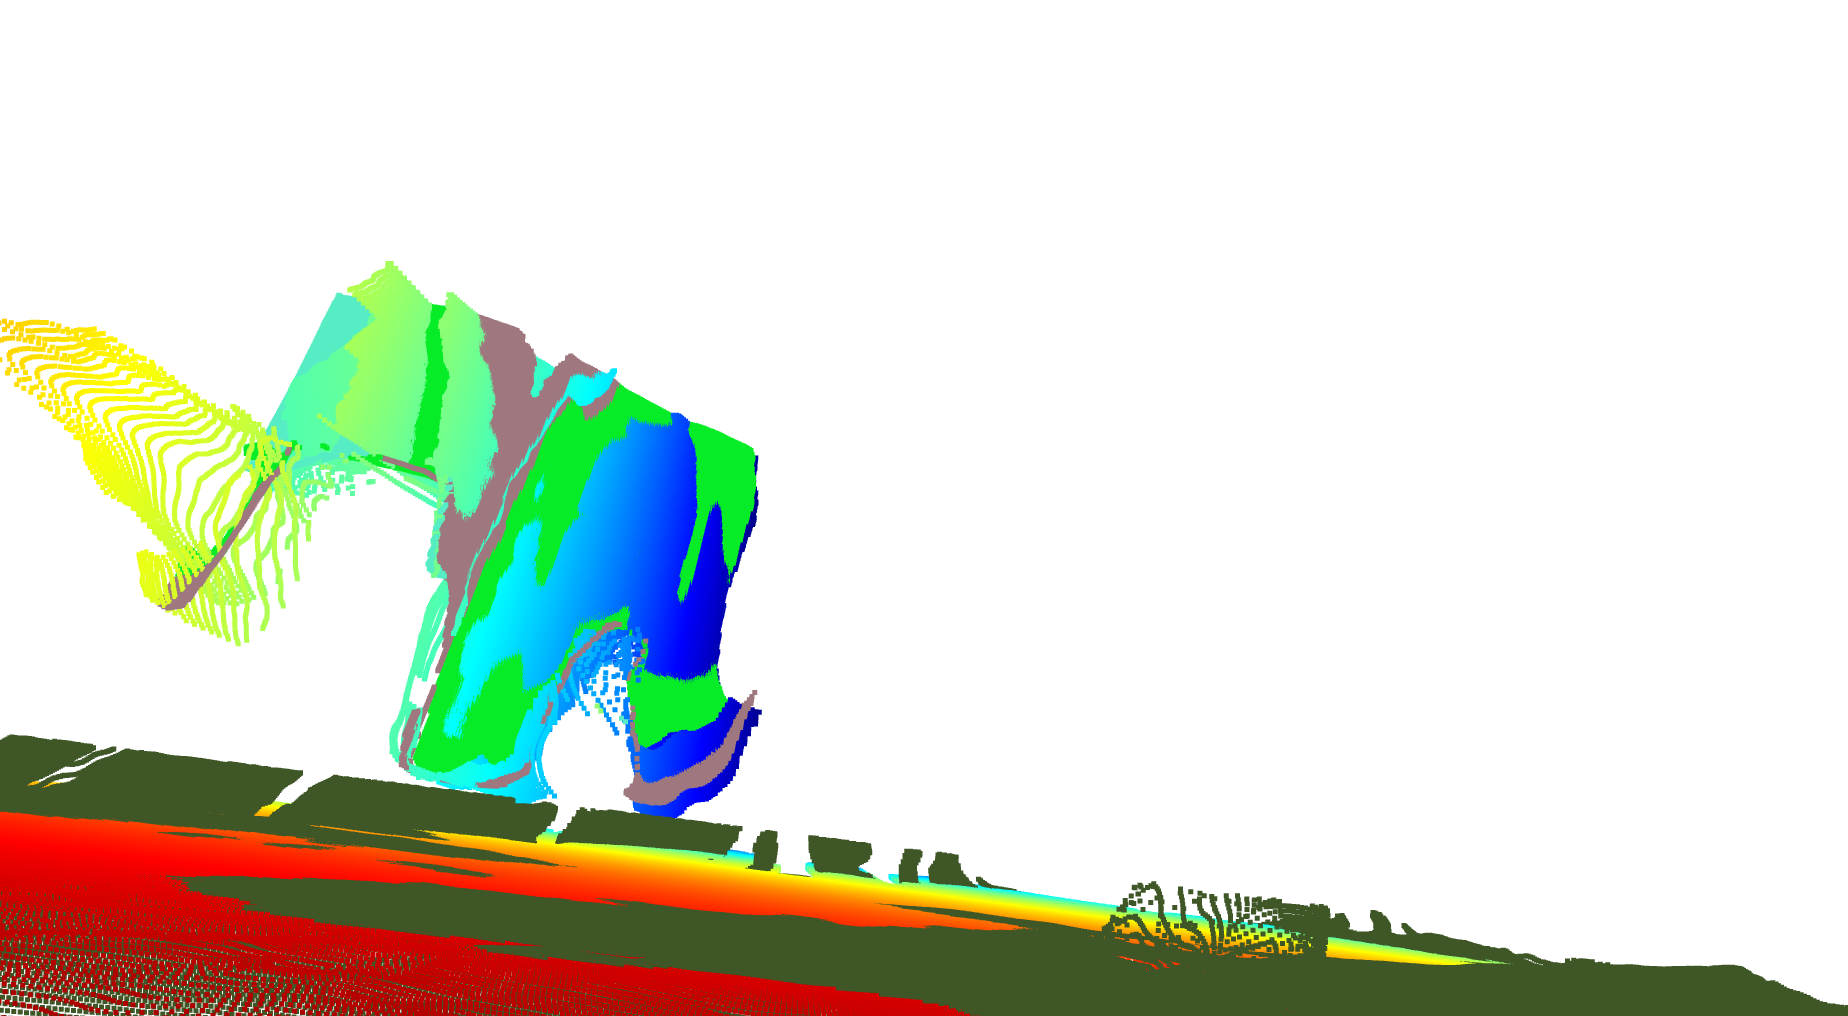

In [297]:
ls_new_pcd.extend(ls_pcd)
o3d.visualization.draw_geometries(ls_new_pcd, zoom=0.35)

In [217]:
def loss_metric(true_pcd: o3d.geometry.PointCloud, approx_pcd: o3d.geometry.PointCloud, func="rmse") -> float:
    """
    :param true_pcd:
    :param approx_pcd:
    :param func:
    :return:
    """
    funcs = {
        "rmse": (lambda x, y: ((x - y) * 1000) ** 2, lambda x, n: np.sqrt(x / n)),
        "mae": (lambda x, y: abs((x - y) * 1000), lambda x, n: x / n), 
        "mse": (lambda x, y: ((x - y) * 1000) ** 2, lambda x, n: x / n)
    }
    true_arr = np.asarray(true_pcd.points)
    approx_arr = np.asarray(approx_pcd.points)
    loss = 0
    for x, y in zip(true_arr, approx_arr):
        loss += funcs[func][0](x[-1], y[-1])
    return funcs[func][1](loss, len(true_arr))


In [223]:
for x, y in zip(ls_new_pcd, ls_pcd):
    print(loss_metric(x, y, "mae"))

0.050223279180685955
0.12421368442303266
0.07274281641571306


In [222]:
arr = [item[-1] * 1000 for item in np.asarray(ls_pcd[0].points)]
min(arr), max(arr)

(-0.503784860484302, -0.16243229038082063)

In [144]:
results = []
for item in tqdm(images):
    tmp = _get_full_cycle(item)
    results.append(tmp[0])

100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


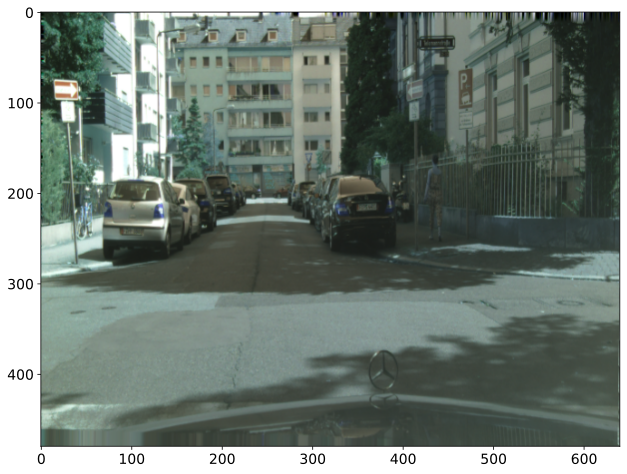

In [145]:
plt.imshow(images[25])

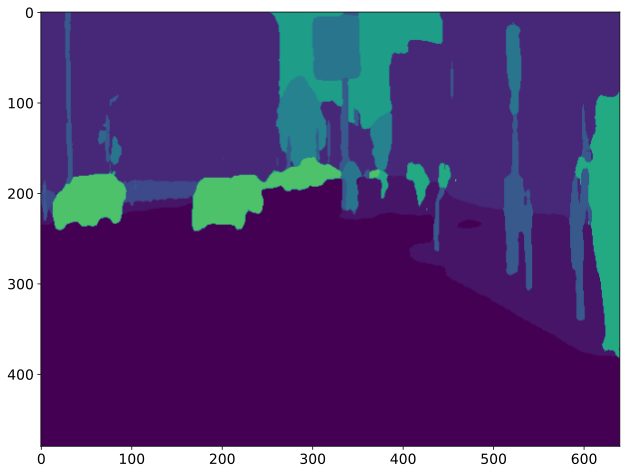

In [177]:
plt.imshow(seg_map)

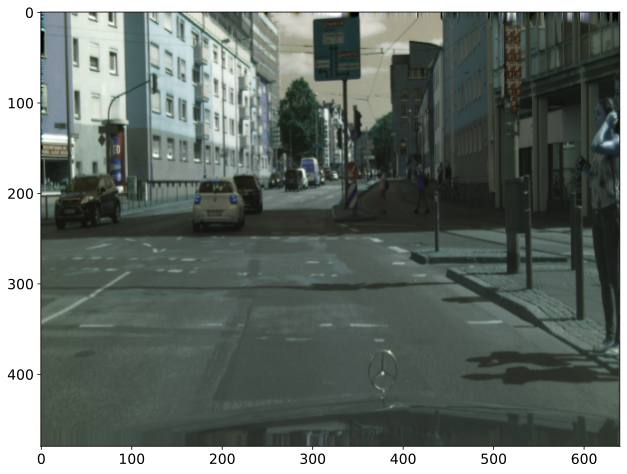

In [164]:
plt.imshow(images[42])

In [165]:
_get_full_cycle(images[42])

(array([[[ 47,  75,  93],
         [ 54,  98, 114],
         [ 87, 116, 130],
         ...,
         [246, 242,  18],
         [246, 242,  18],
         [246, 242,  18]],
 
        [[ 70, 155, 149],
         [ 86, 154, 152],
         [100, 151, 152],
         ...,
         [246, 242,  18],
         [246, 242,  18],
         [246, 242,  18]],
 
        [[  0,  93, 117],
         [ 23, 110, 128],
         [ 66, 123, 138],
         ...,
         [246, 242,  18],
         [246, 242,  18],
         [246, 242,  18]],
 
        ...,
 
        [[ 19, 165,  94],
         [ 19, 165,  94],
         [ 19, 165,  94],
         ...,
         [ 19, 165,  94],
         [ 19, 165,  94],
         [ 19, 165,  94]],
 
        [[ 19, 165,  94],
         [ 19, 165,  94],
         [ 19, 165,  94],
         ...,
         [ 19, 165,  94],
         [ 19, 165,  94],
         [ 19, 165,  94]],
 
        [[ 19, 165,  94],
         [ 19, 165,  94],
         [ 19, 165,  94],
         ...,
         [ 19, 165,  94],
  

In [93]:
ls = [np.array([-5.34818325e-03,  9.90715293e-01,  1.35847731e-01,  1.02705437e-04]),
      np.array([ 8.09042258e-01,  5.86096406e-01,  4.40639041e-02, -2.82121365e-04]),
      np.array([ 8.23964835e-01,  5.66346362e-01,  1.82688021e-02, -2.73732701e-04]),
      np.array([ 9.81760995e-01,  1.79970145e-01, -6.12869921e-02, -3.00046718e-04])]

In [114]:
ff = dist(_distance_func)
ff(ls)

array([[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 6.39067415e-04, 1.00000000e+00],
       [1.00000000e+00, 6.39067415e-04, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [98]:
def distance_matrix_np(pts):
    """Returns matrix of pairwise Euclidean distances. Vectorized numpy version."""
    return np.sum(distance_func(, -1)**0.5

array([[0.00000000e+00, 4.17686308e-01, 4.40836990e-01, 8.35277201e-01],
       [4.17686308e-01, 0.00000000e+00, 6.39067401e-04, 1.02934548e-01],
       [4.40836990e-01, 6.39067401e-04, 0.00000000e+00, 9.02576597e-02],
       [8.35277201e-01, 1.02934548e-01, 9.02576597e-02, 0.00000000e+00]])

In [105]:
pdist(np.array(ls), distance_func)

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 6.39067415e-04,
       1.00000000e+00, 1.00000000e+00])

In [99]:
distance_matrix_np(np.array(ls))

array([[0.        , 0.91398723, 0.93897498, 1.29249932],
       [0.91398723, 0.        , 0.03575101, 0.45372802],
       [0.93897498, 0.03575101, 0.        , 0.42487096],
       [1.29249932, 0.45372802, 0.42487096, 0.        ]])

In [102]:
np.array(ls)[:, None]

array([[[-5.34818325e-03,  9.90715293e-01,  1.35847731e-01,
          1.02705437e-04]],

       [[ 8.09042258e-01,  5.86096406e-01,  4.40639041e-02,
         -2.82121365e-04]],

       [[ 8.23964835e-01,  5.66346362e-01,  1.82688021e-02,
         -2.73732701e-04]],

       [[ 9.81760995e-01,  1.79970145e-01, -6.12869921e-02,
         -3.00046718e-04]]])

In [97]:
clust.fit_predict(ls)

array([1, 0, 0, 0])

In [91]:
help(ds.cosine)

Help on function cosine in module scipy.spatial.distance:

cosine(u, v, w=None)
    Compute the Cosine distance between 1-D arrays.
    
    The Cosine distance between `u` and `v`, is defined as
    
    .. math::
    
        1 - \frac{u \cdot v}
                  {||u||_2 ||v||_2}.
    
    where :math:`u \cdot v` is the dot product of :math:`u` and
    :math:`v`.
    
    Parameters
    ----------
    u : (N,) array_like
        Input array.
    v : (N,) array_like
        Input array.
    w : (N,) array_like, optional
        The weights for each value in `u` and `v`. Default is None,
        which gives each value a weight of 1.0
    
    Returns
    -------
    cosine : double
        The Cosine distance between vectors `u` and `v`.
    
    Examples
    --------
    >>> from scipy.spatial import distance
    >>> distance.cosine([1, 0, 0], [0, 1, 0])
    1.0
    >>> distance.cosine([100, 0, 0], [0, 1, 0])
    1.0
    >>> distance.cosine([1, 1, 0], [0, 1, 0])
    0.29289321881345

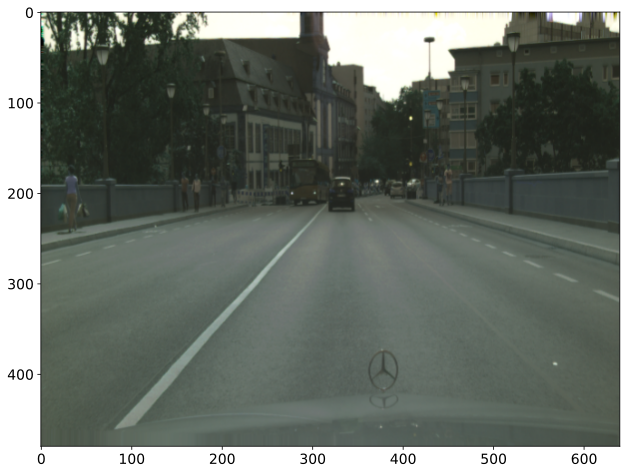

In [86]:
plt.imshow(images[3])

In [77]:
_get_full_cycle(images[25])

IndexError: tuple index out of range

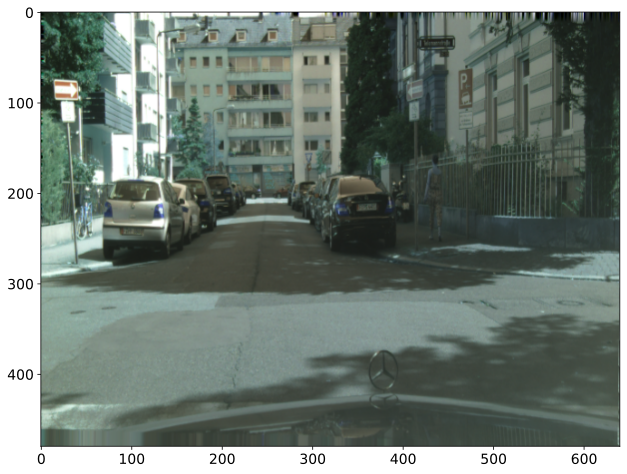

In [78]:
plt.imshow(images[25])

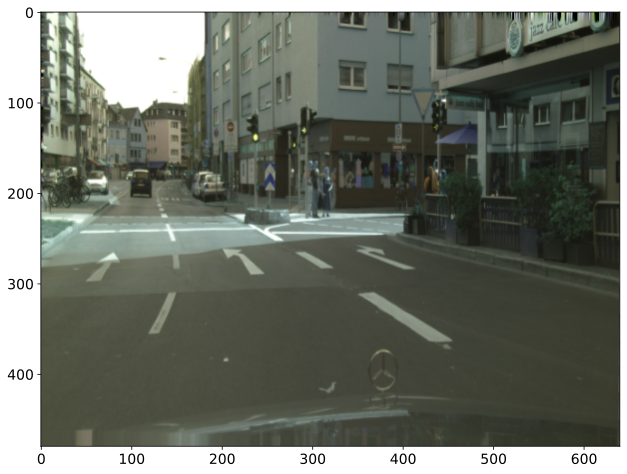

In [60]:
plt.imshow(images[4])

In [68]:
res[1]

[array([1.29562004e-02, 9.91125173e-01, 1.32299013e-01, 1.09639245e-04]),
 array([ 9.91331320e-01,  8.50165533e-02,  7.47641818e-02, -2.54681312e-04])]

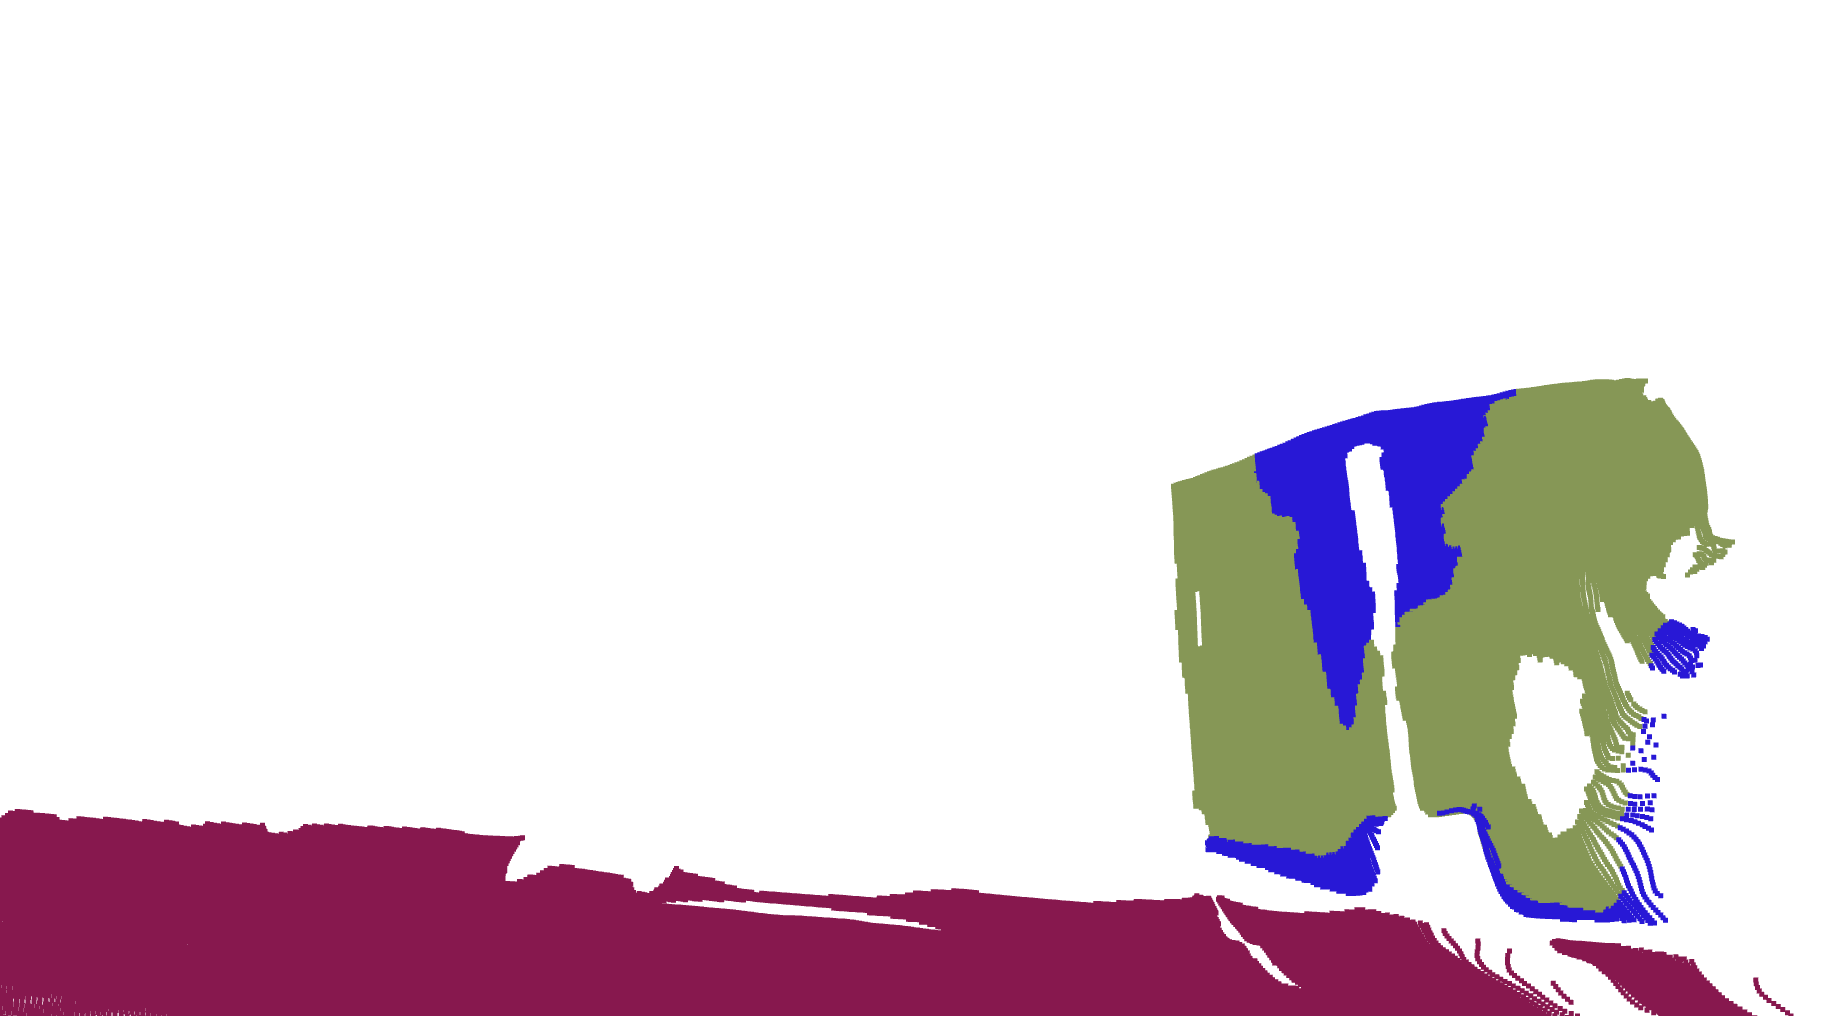

In [176]:
o3d.visualization.draw_geometries(ls_pcd, zoom=0.35)

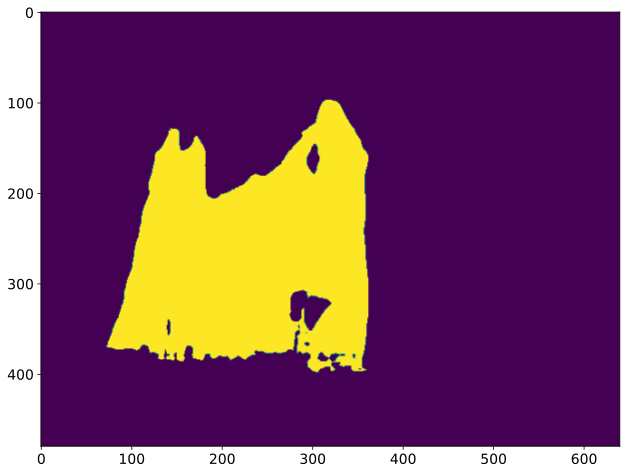

In [28]:
plt.imshow(ls_maps_planes[1])

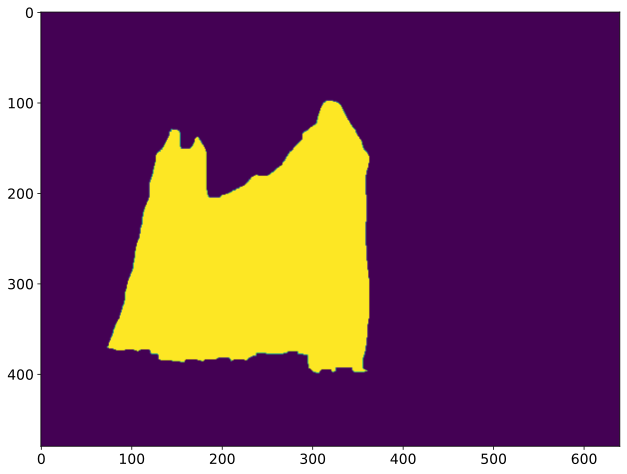

In [29]:
plt.imshow(close_map(ls_maps_planes[1]))

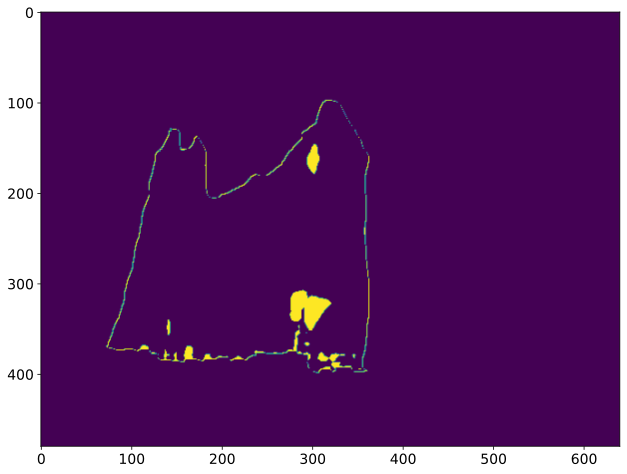

In [31]:
plt.imshow(np.logical_xor(close_map(ls_maps_planes[1]), ls_maps_planes[1]))

In [36]:
segm_model.model

hardnet(
  (base): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): ConvLayer(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): ConvLayer(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

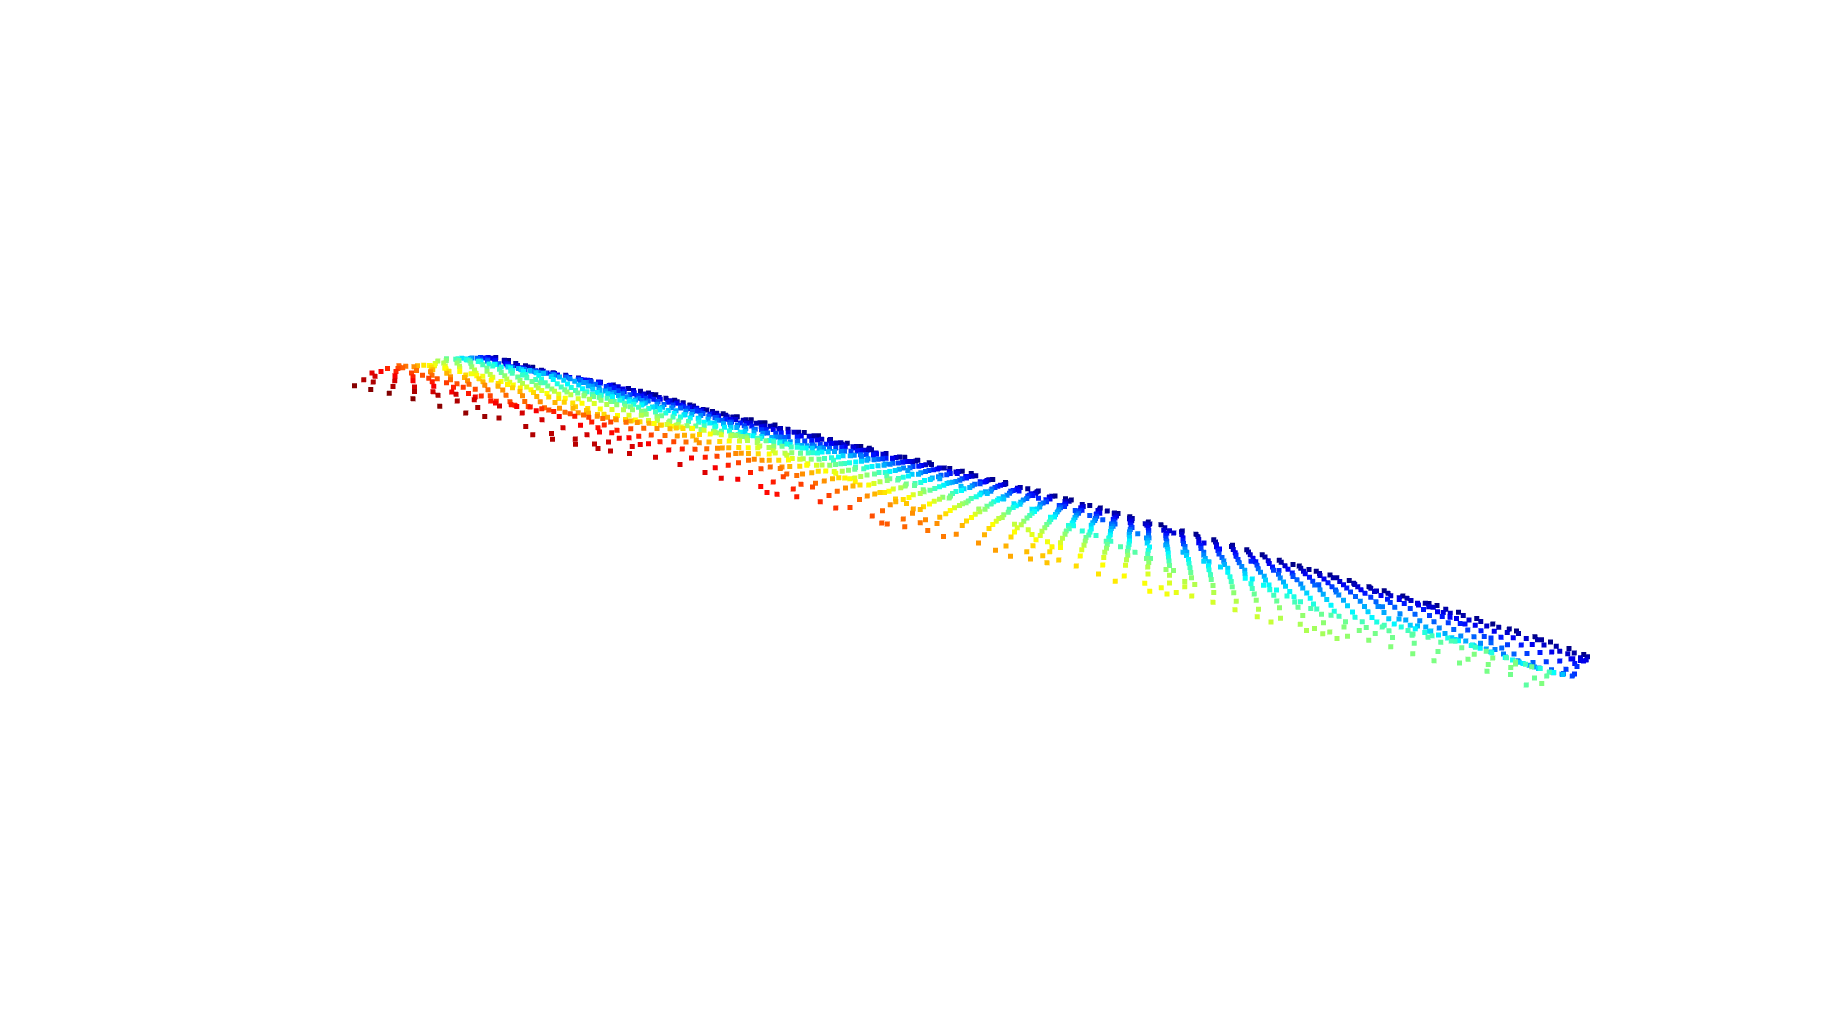

In [134]:
o3d.visualization.draw_geometries([downs], zoom=0.35)

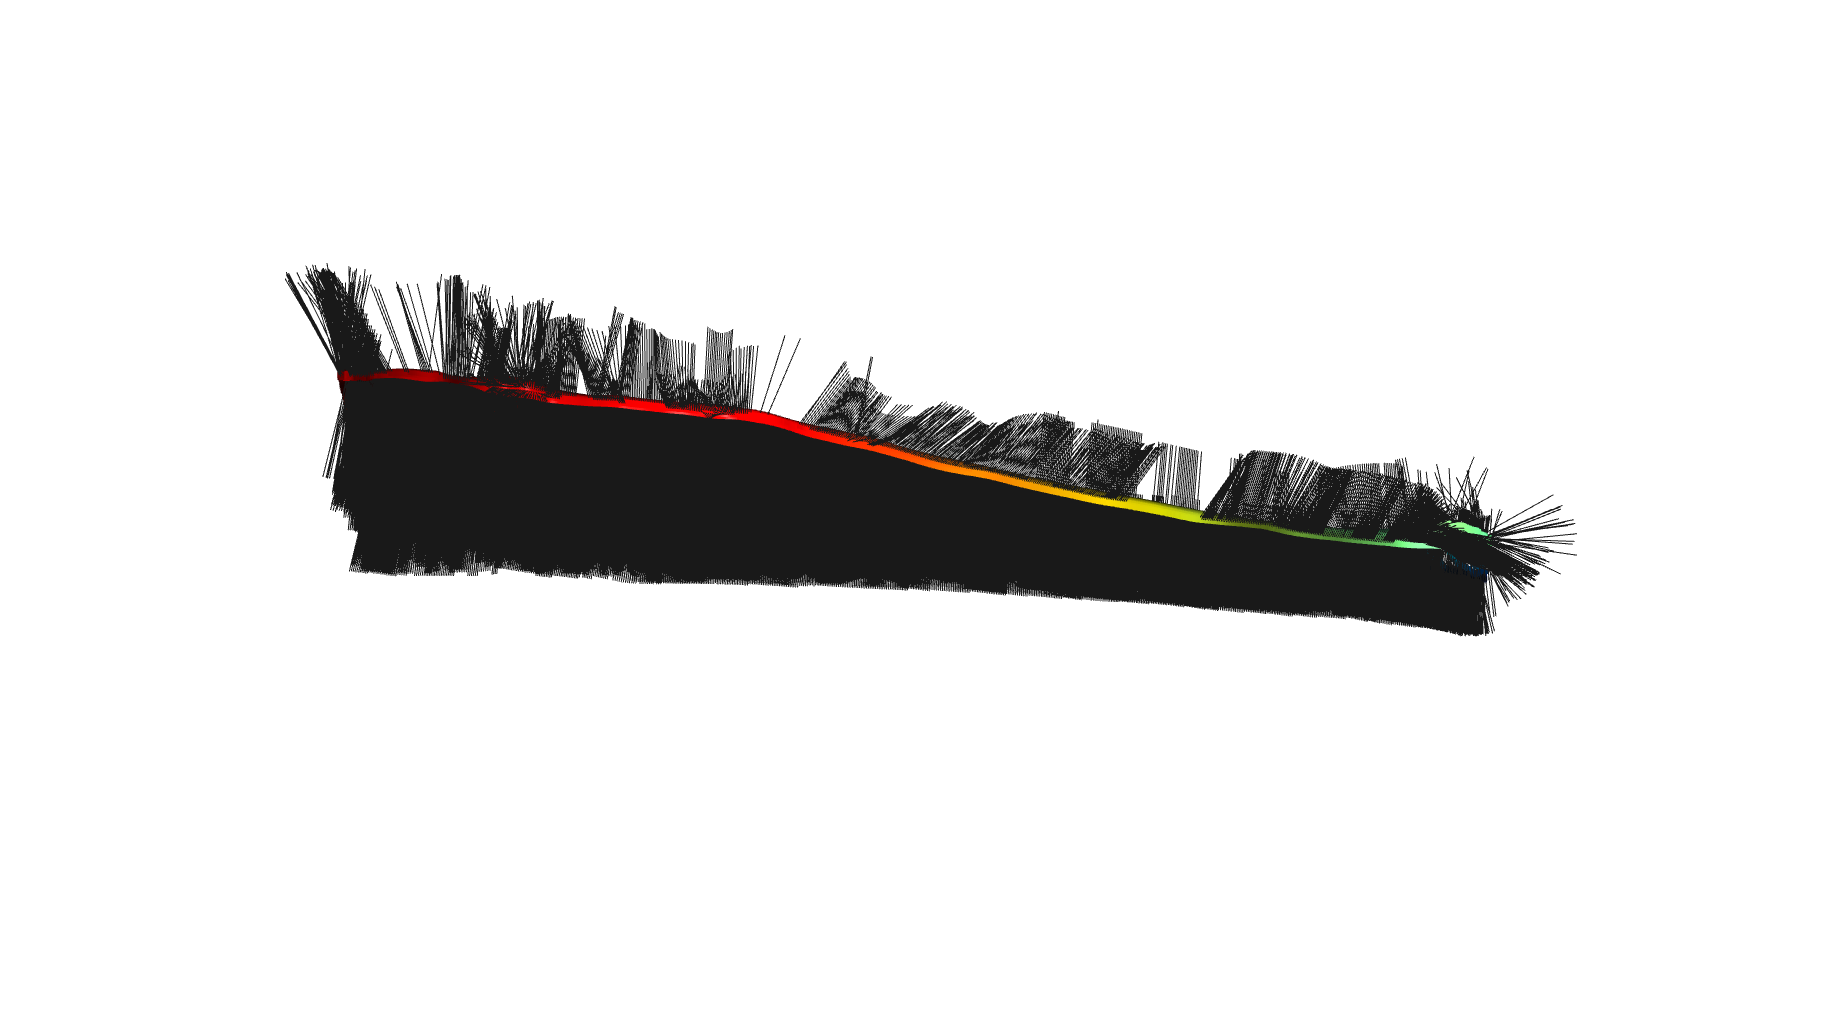

In [135]:
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
o3d.visualization.draw_geometries([pcd], zoom=0.35)

Plane equation: 0.06x + 0.98y + -0.21z + 0.00 = 0


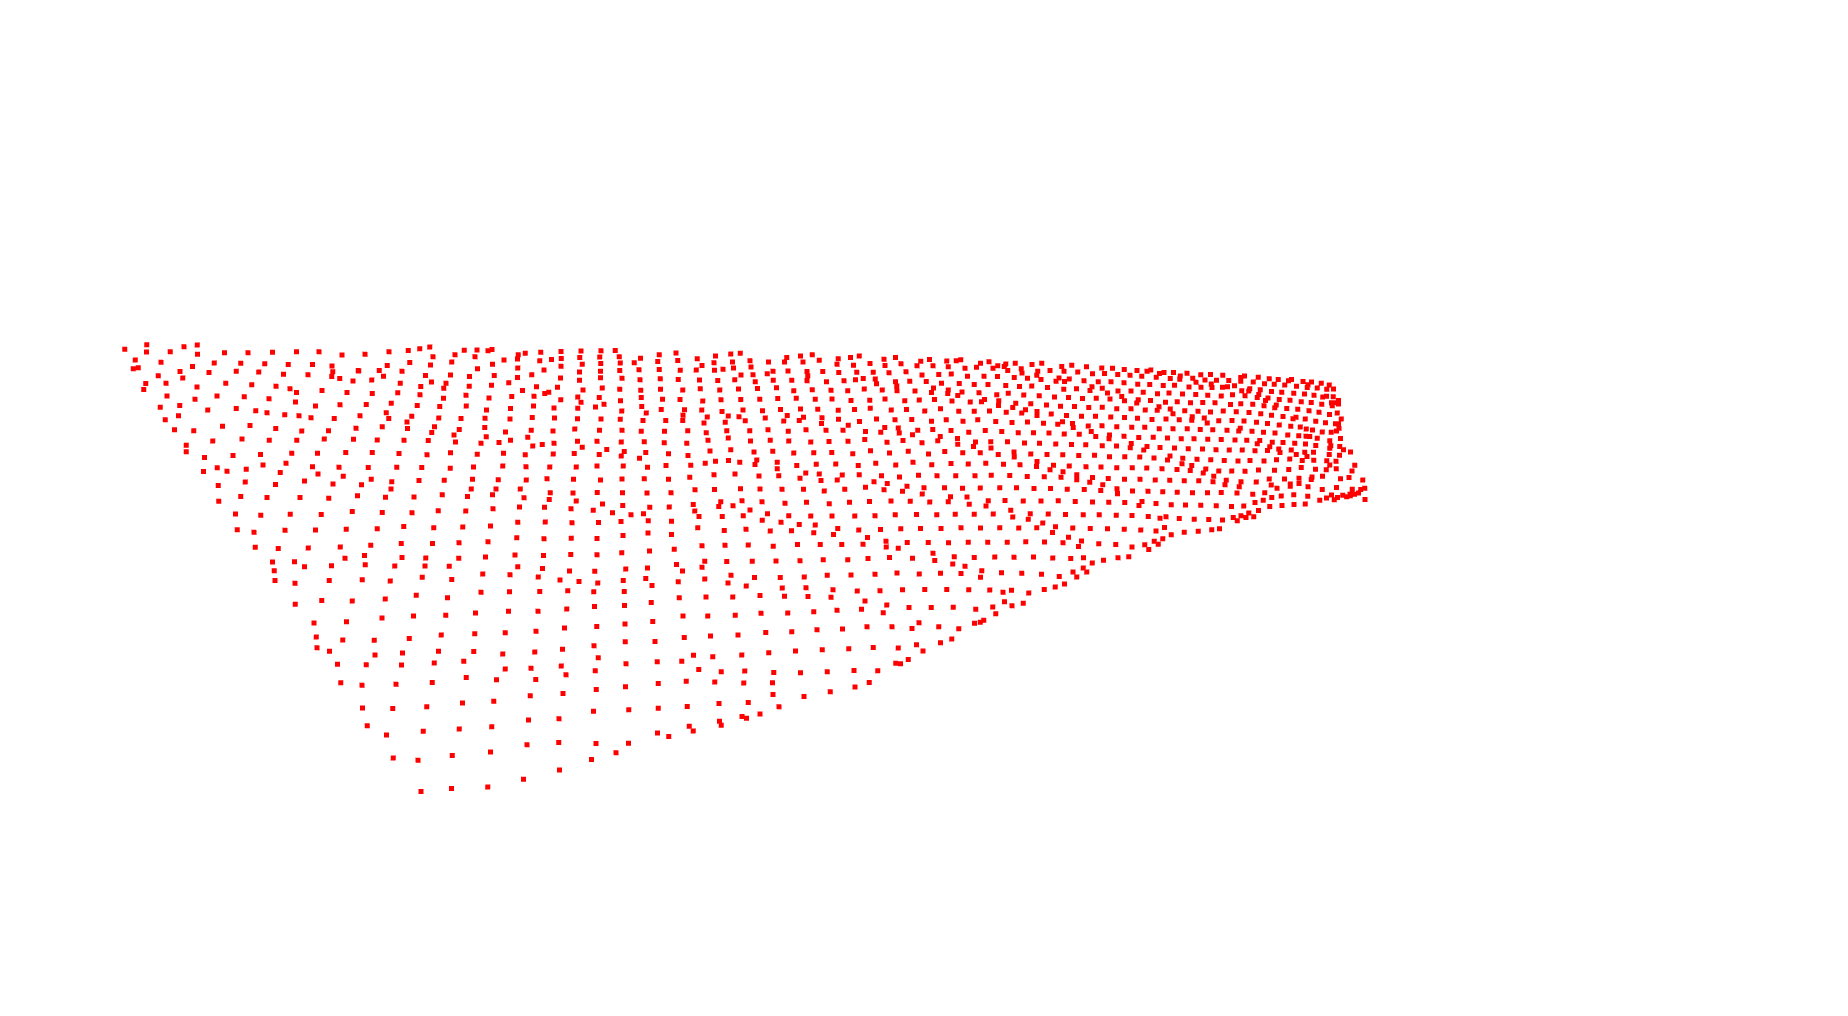

In [136]:
plane_model, inliers = downs.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downs.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downs.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [138]:
downs.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))


True

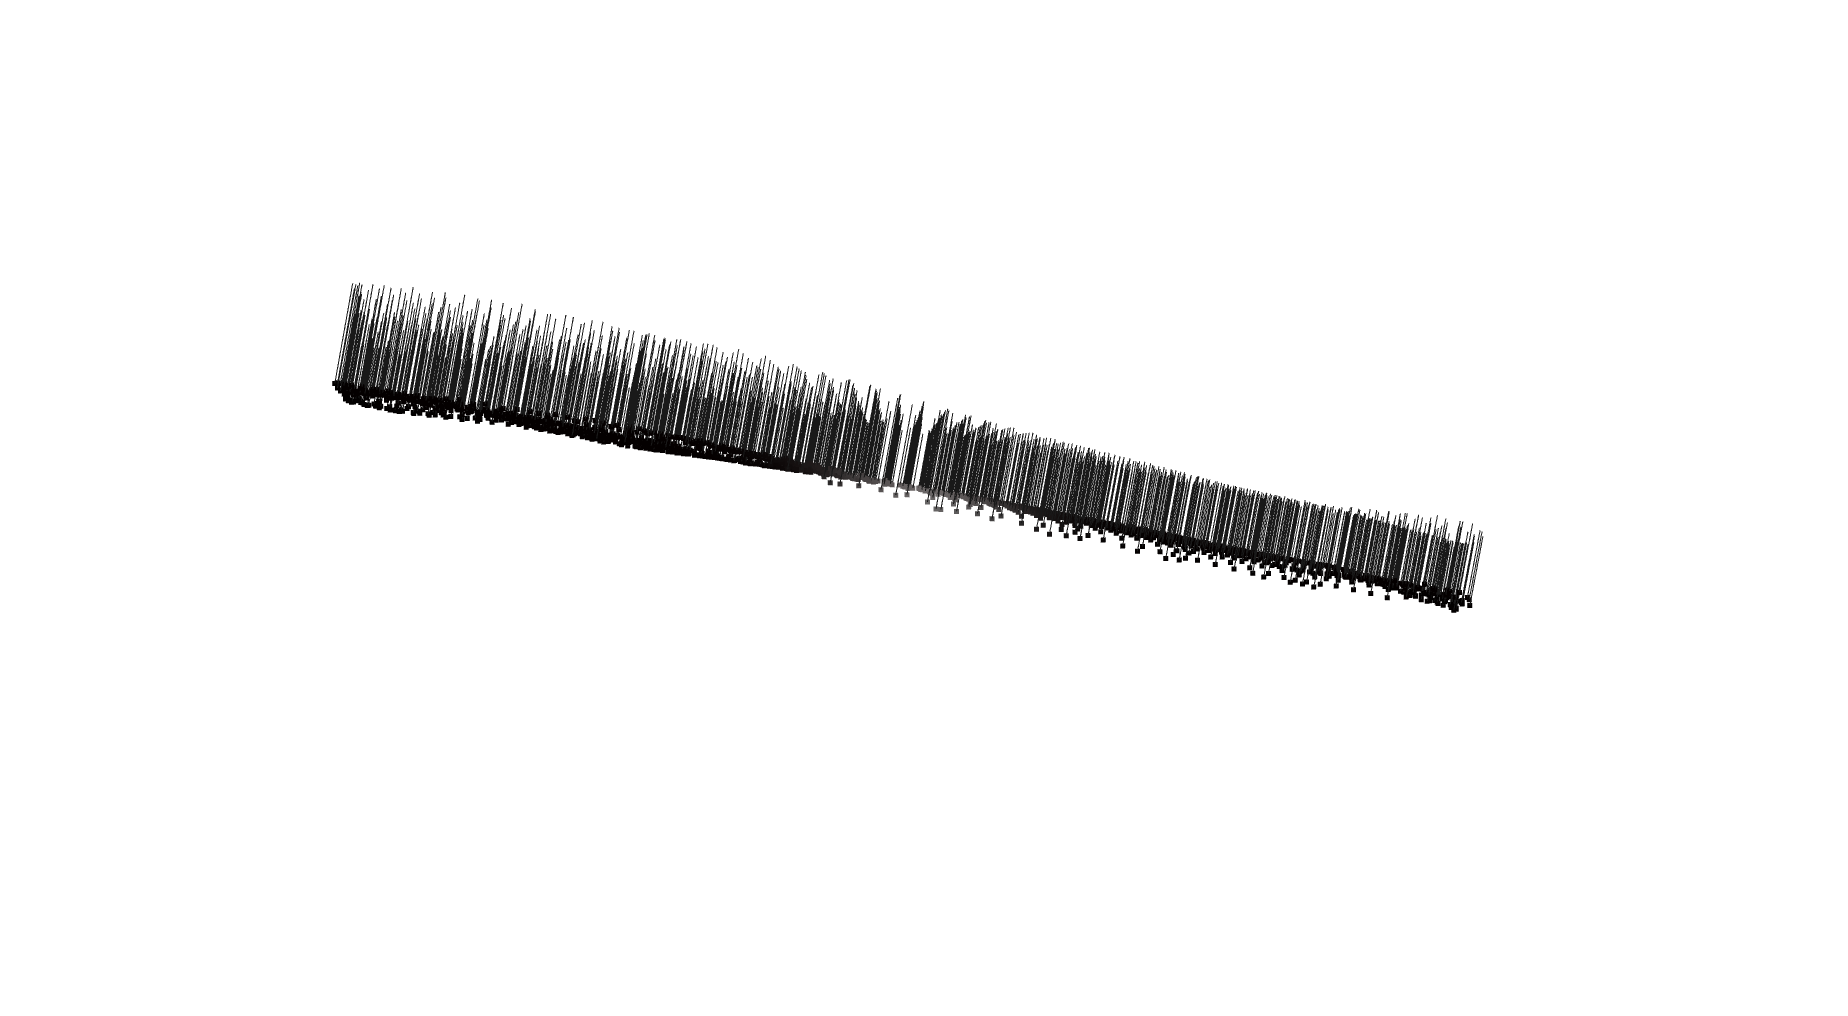

In [139]:
downs.normals = o3d.utility.Vector3dVector(np.array([np.array([a, b, c]) for _ in range(np.asarray(downs.normals).shape[0])]))

inlier_cloud1 = downs.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downs.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)

In [99]:
udowns = pcd.uniform_down_sample(4)

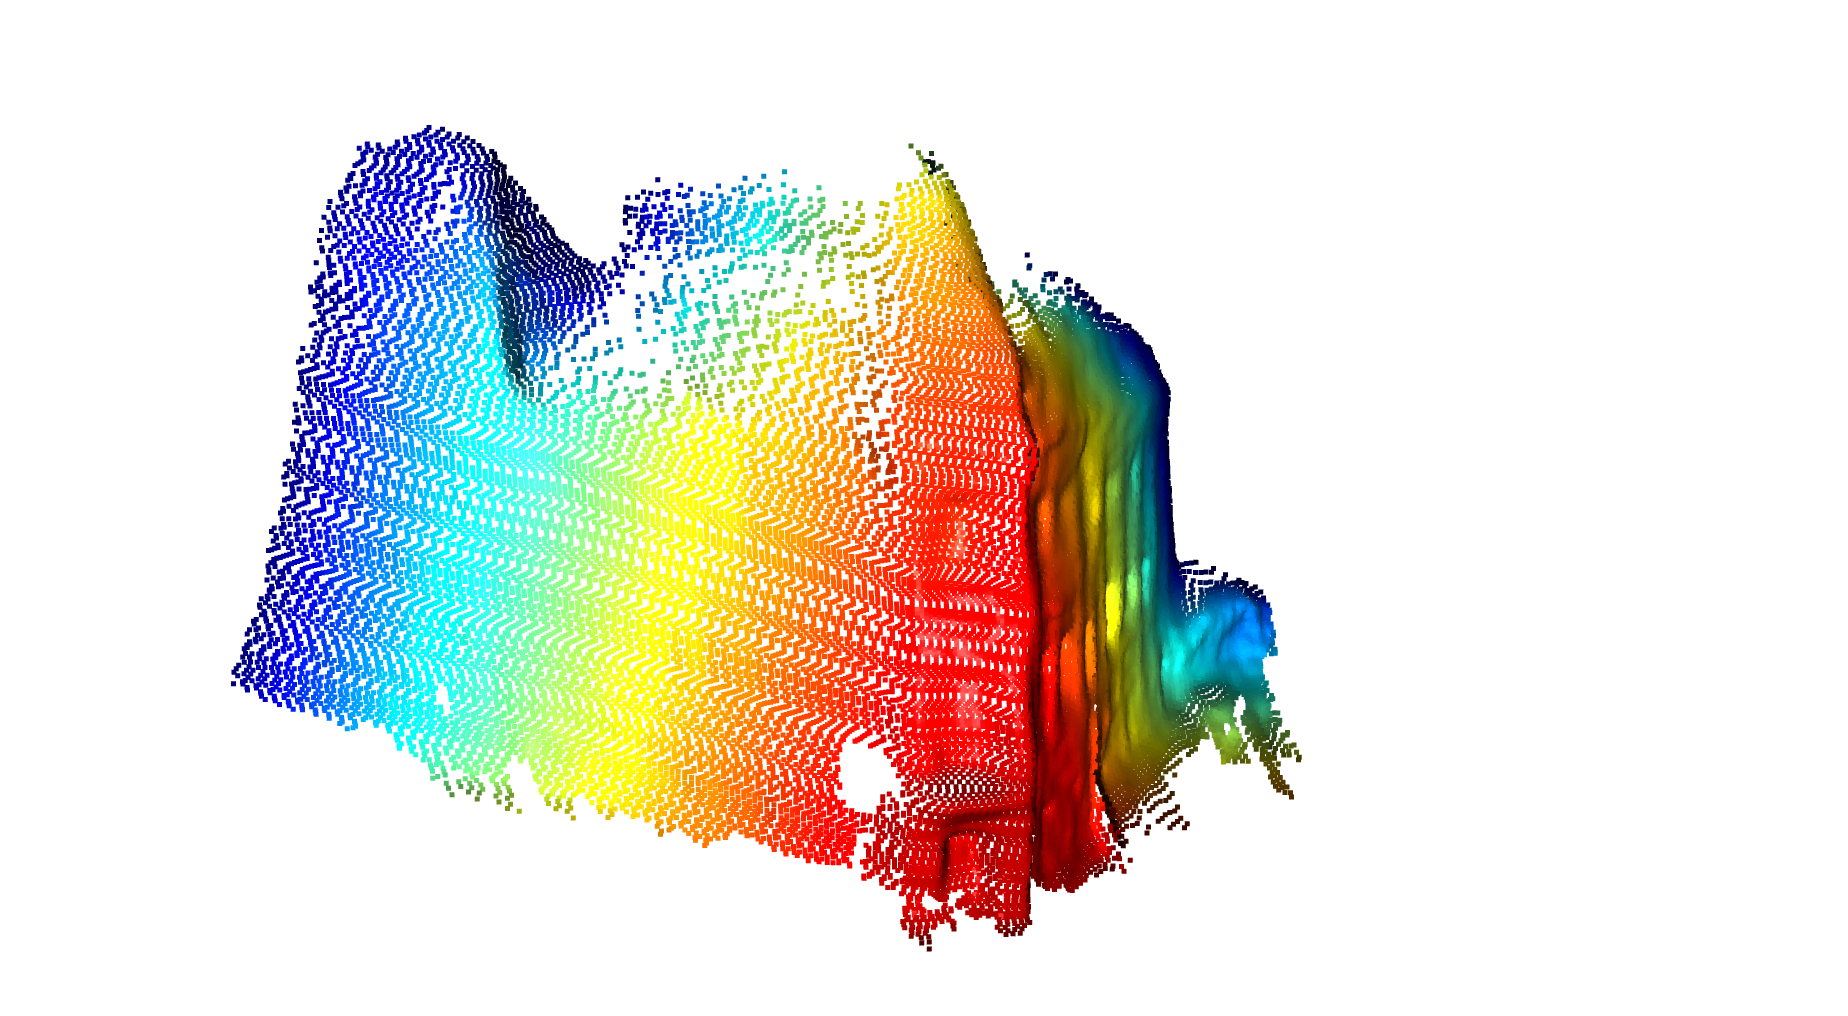

In [101]:
o3d.visualization.draw_geometries([udowns],
                                  zoom=0.35)

In [115]:
np.asarray(pcd.points).shape

(166889, 3)

Plane equation: 0.96x + 0.01y + 0.26z + 0.00 = 0


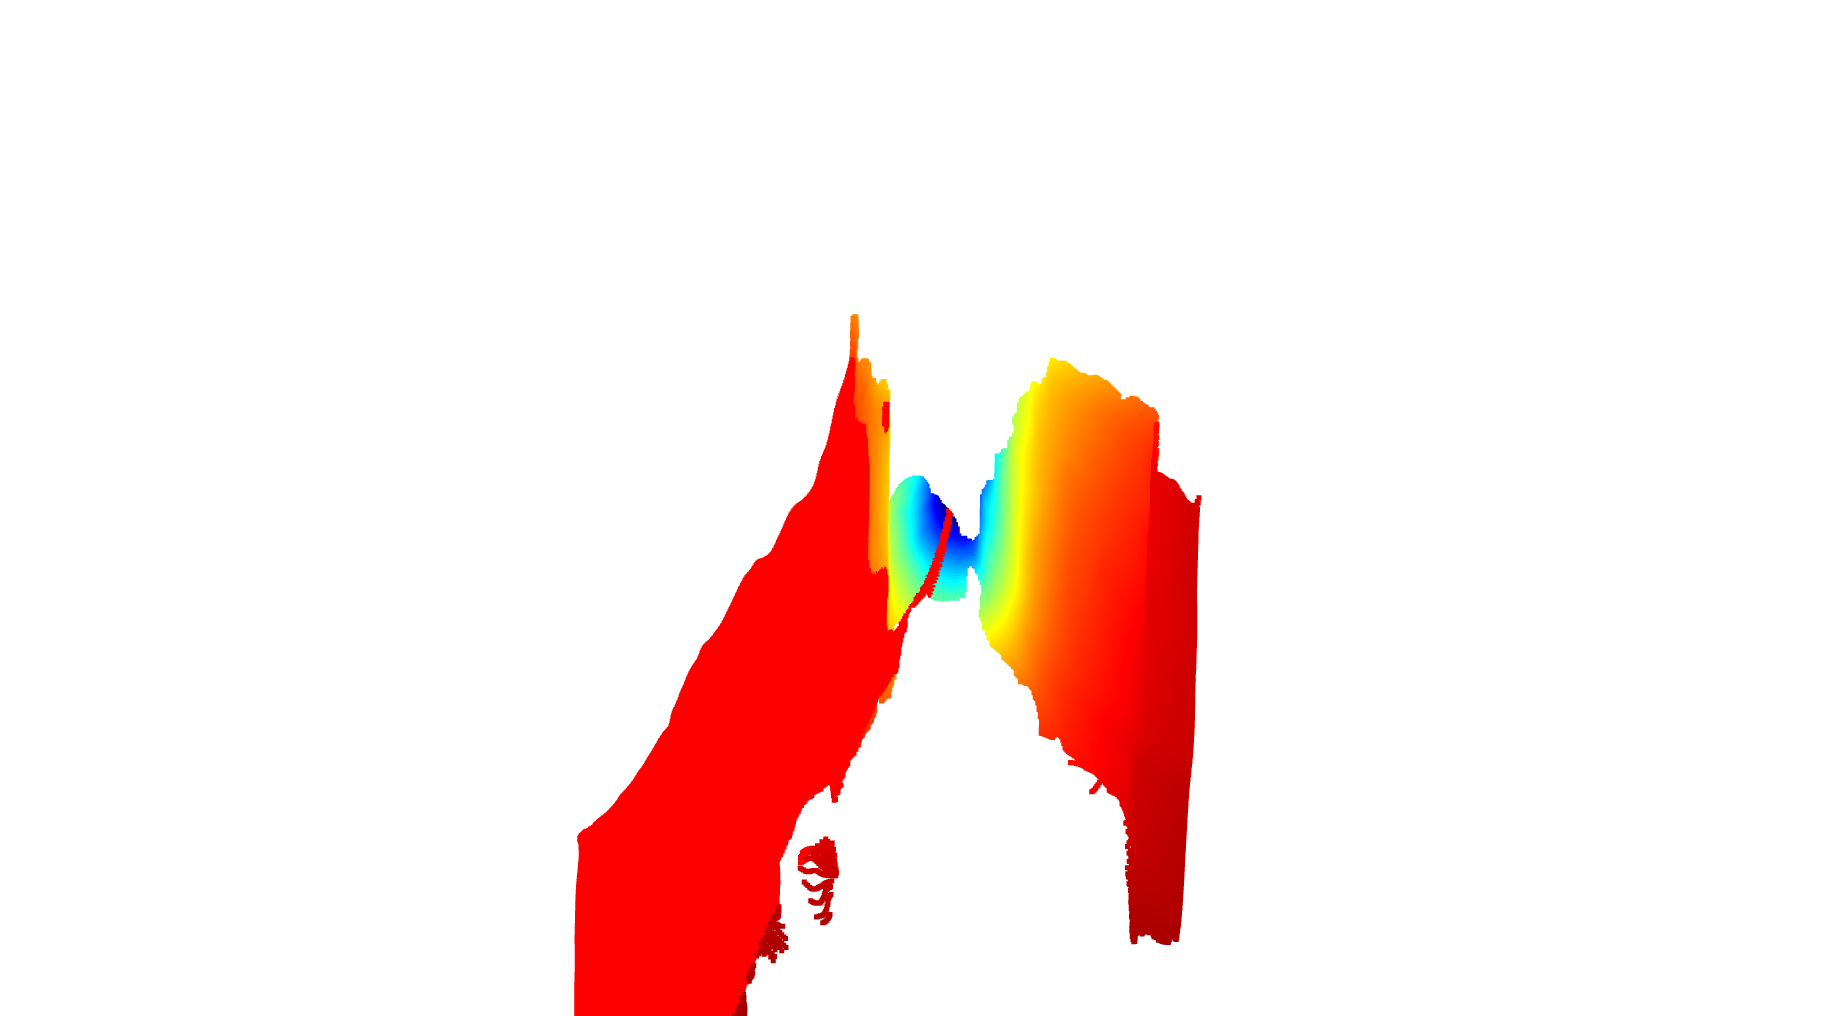

In [113]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=300)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [114]:
np.asarray(inlier_cloud.points).shape

(120666, 3)

Plane equation: 0.97x + -0.17y + 0.19z + -0.00 = 0


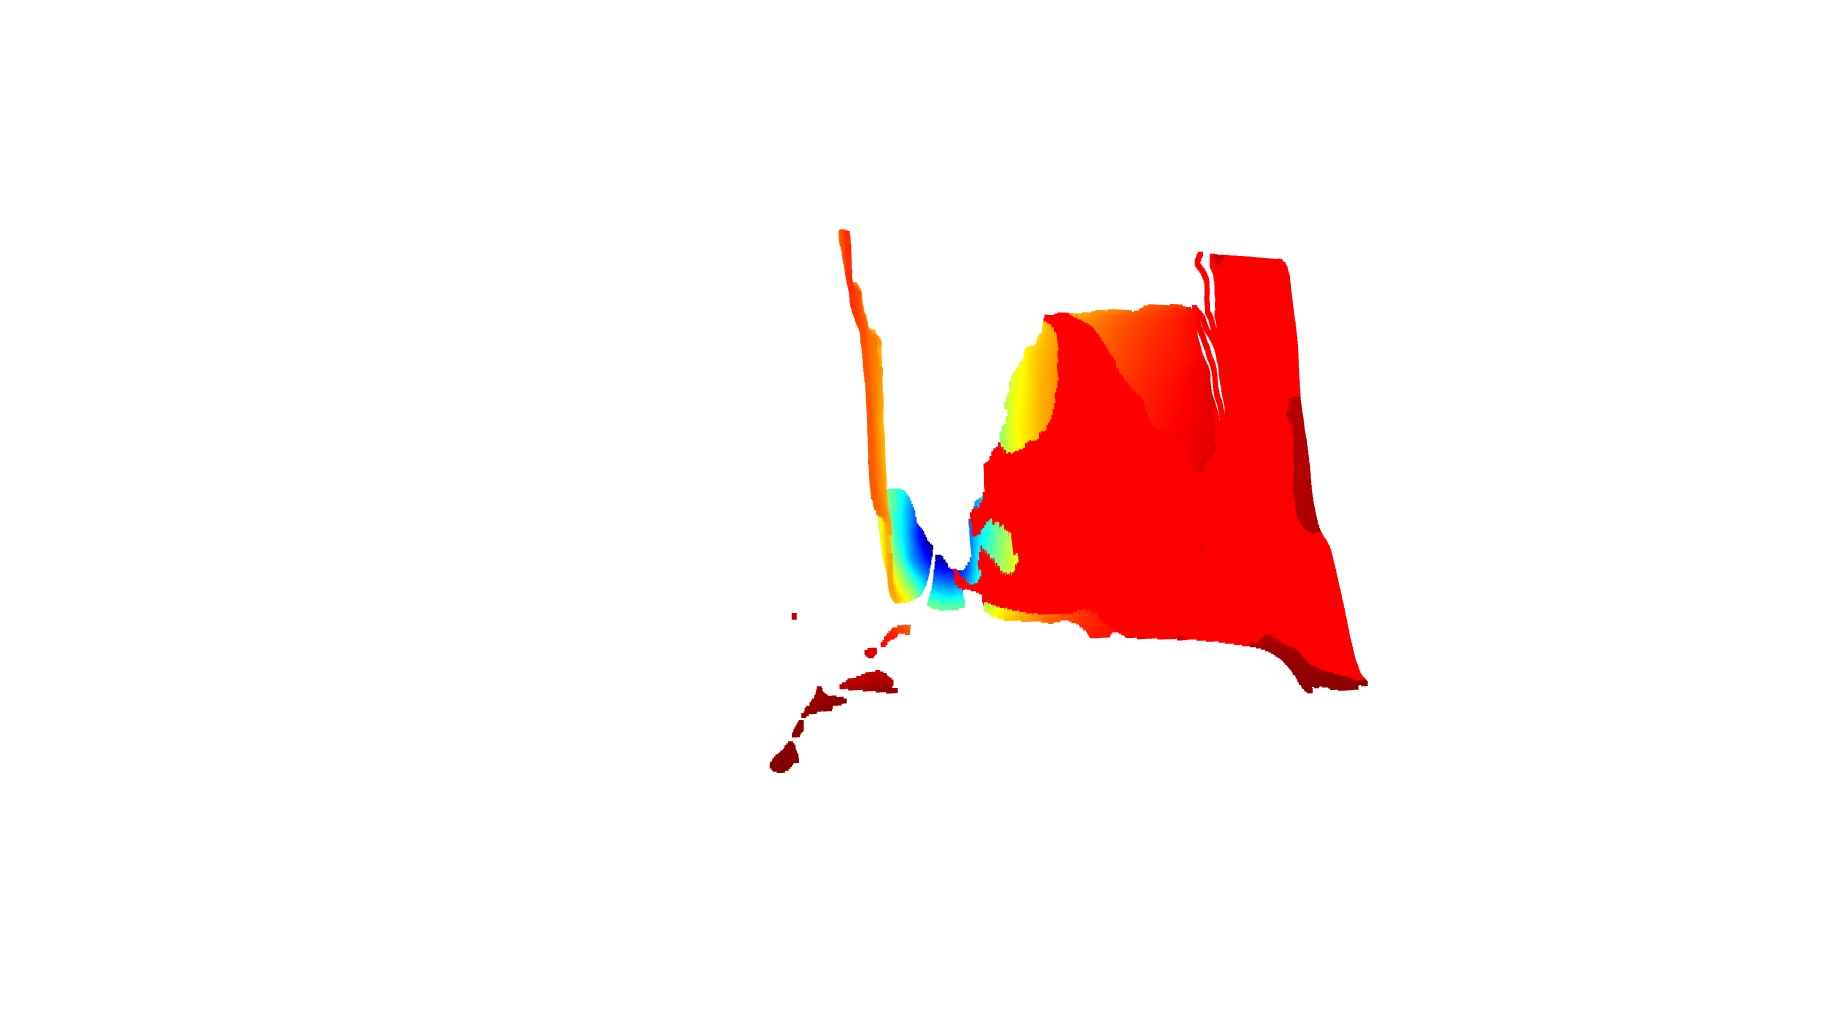

In [116]:
plane_model, inliers = outlier_cloud.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=300)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = outlier_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = outlier_cloud.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [118]:
help(cv2.connectedComponentsWithAlgorithm)

Help on built-in function connectedComponentsWithAlgorithm:

connectedComponentsWithAlgorithm(...)
    connectedComponentsWithAlgorithm(image, connectivity, ltype, ccltype[, labels]) -> retval, labels
    .   @brief computes the connected components labeled image of boolean image
    .   
    .   image with 4 or 8 way connectivity - returns N, the total number of labels [0, N-1] where 0
    .   represents the background label. ltype specifies the output label image type, an important
    .   consideration based on the total number of labels or alternatively the total number of pixels in
    .   the source image. ccltype specifies the connected components labeling algorithm to use, currently
    .   Grana (BBDT) and Wu's (SAUF) algorithms are supported, see the #ConnectedComponentsAlgorithmsTypes
    .   for details. Note that SAUF algorithm forces a row major ordering of labels while BBDT does not.
    .   This function uses parallel version of both Grana and Wu's algorithms if at leas